In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [ ]:
data = pd.read_csv('kobe.csv')

In [ ]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [ ]:
target = 'shot_made_flag'

# Задание

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

### Функции для анализа

In [ ]:
# Для поиска выбросов будем использовать boxplot, pairplot
def get_boxplot(X, columns=None):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.boxplot(x=X[i])
    plt.show()
  pass  

def get_pairplot(X, columns=None):
  if columns is None:
    columns = X.columns

  sns.pairplot(X[columns])
  pass

def get_hist(X, columns=None, bins='auto'):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.histplot(x=X[i], bins=bins)
    plt.grid()
    plt.show()
  pass

def get_heatmap(X, columns=None, target=None, thres=0.5):
  if columns is None:
    columns = X.columns

  # если задана целевая переменная - вывести только те переменные
  # из columns, у которых корреляция с целевой выше порога 
  if target is not None:
    columns = X[columns].corr().index[abs(X[columns].corr()[target]) > thres]
 
  sns.heatmap(X[columns].corr(), cmap='coolwarm', annot = True, )
  pass

# По каждому признаку - число уникальных значений и тип
def get_stats(df, unic='all', limit=50, stats=True, print_counts=True):
  if stats:
    print('{0:<20} {1:>10} | {2:>10} | {3}\n'.format('Название колонки', 'Пустых', 'Уникальных', 'Тип данных')+'-'*57)
    for col in df.columns:
      print(f'{col:<20} {df[col].isnull().sum():>10} | {len(df[col].value_counts()):>10} | {df[col].dtype}')
  
  if print_counts:
      for col in df.columns:
        if len(df[col].value_counts())<limit+1:
          if unic=='object':
            if df[col].dtype=='object':
              print(f'\n{col}\n{"-"*57}')
              print(f'{df[col].value_counts()}\n{"-"*57}')
          else:
              print(f'\n{col}\n{"-"*57}')
              print(f'{df[col].value_counts()}\n{"-"*57}')          

  pass

# Решение

### Описательная статистика

Выведем список пустых и количество уникальных, с помощью моей функции:

In [ ]:
get_stats(data, print_counts=False)

Название колонки         Пустых | Уникальных | Тип данных
---------------------------------------------------------
action_type                   0 |         57 | object
combined_shot_type            0 |          6 | object
game_event_id                 0 |        620 | int64
game_id                       0 |       1559 | int64
lat                           0 |        457 | float64
loc_x                         0 |        489 | int64
loc_y                         0 |        457 | int64
lon                           0 |        489 | float64
minutes_remaining             0 |         12 | int64
period                        0 |          7 | int64
playoffs                      0 |          2 | int64
season                        0 |         20 | object
seconds_remaining             0 |         60 | int64
shot_distance                 0 |         74 | int64
shot_made_flag             5000 |          2 | float64
shot_type                     0 |          2 | object
shot_zone_area            

Сразу понятно, что некоторые идентификационные, дублирующиеся или незначные поля можно удалить:

In [ ]:
data.drop(columns=['team_id', 'team_name', 'game_date',
                   'shot_id', 'game_id', 'game_event_id'], inplace=True)

In [ ]:
#Находим категориальные  и числовые признаки
cat_features = list(data.columns[data.dtypes == object])
int_features = list(set(data.columns) - set(cat_features))

### Работа с выбросами

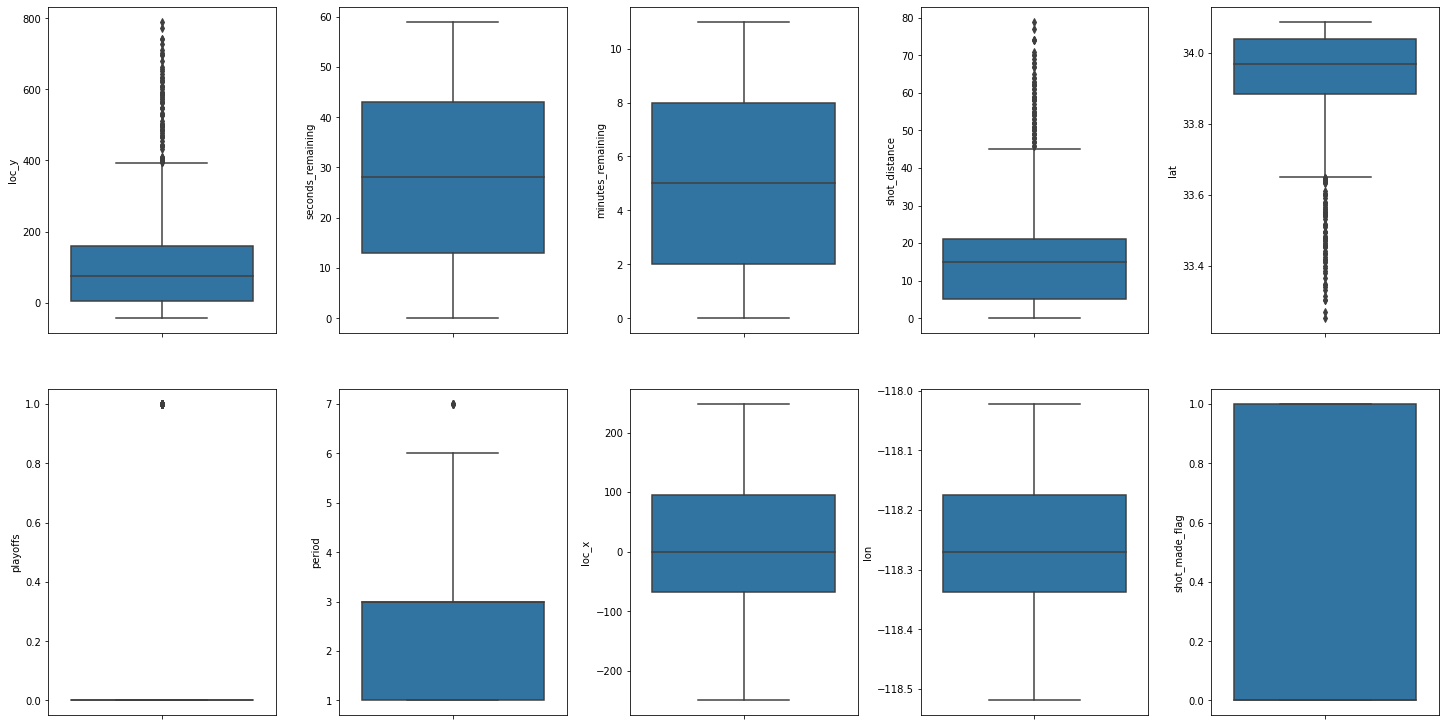

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data[int_features].items():
  sns.boxplot(y=k, data=data[int_features], ax=axs[index])
  index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

По переменной shot_distance видно - что это случайные броски наудачу, выполняемые в последние секунды с больших расстояний. Эти показатели дистанции имеют низкую частоту и их не так много, так что удаляем как выбросы

In [ ]:
len(data[data.shot_distance>40])

90

In [ ]:
data = data[data.shot_distance<40]

Выведем еще раз графики выбросов:

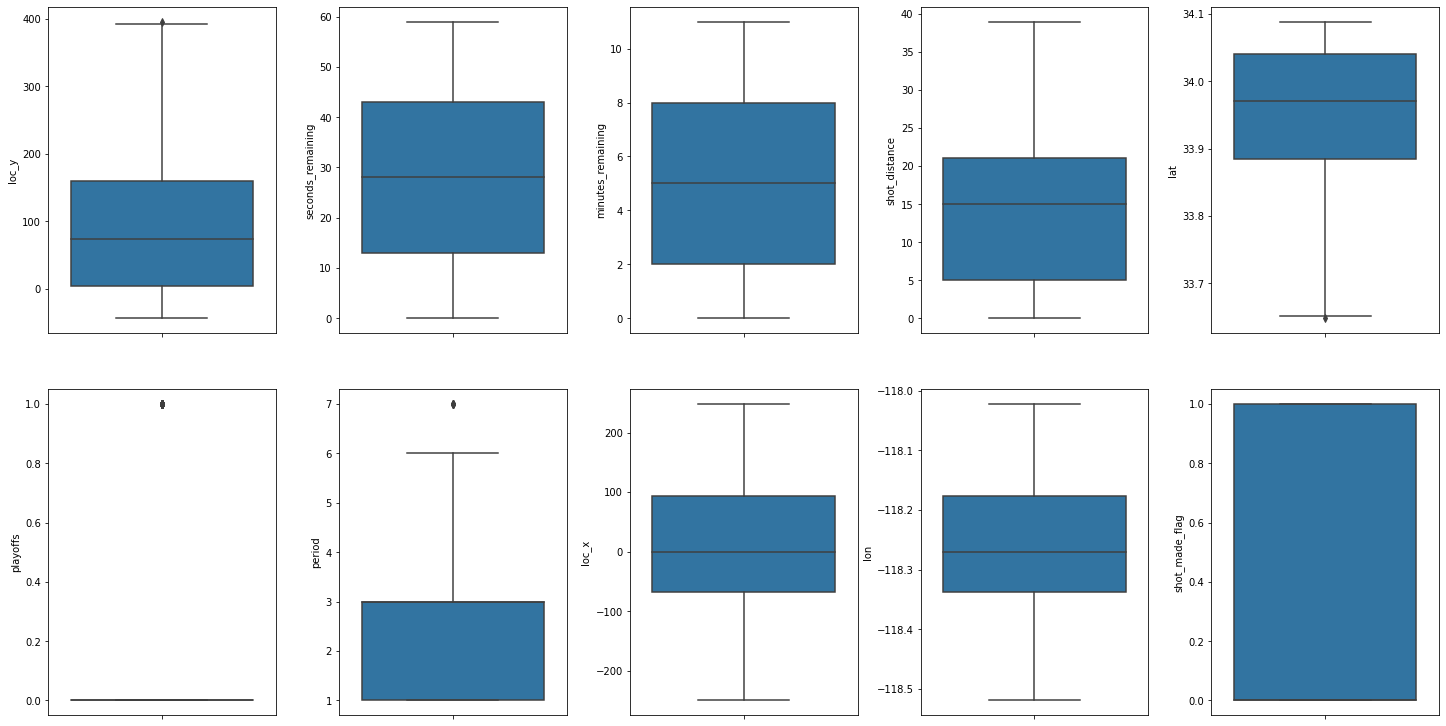

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data[int_features].items():
  sns.boxplot(y=k, data=data[int_features], ax=axs[index])
  index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Выбросы со значением 7 фигурируют в переменной period, это потому, что в баскетбольном матче 4 периода, а остальные - это овертаймы. Наступление 7-го периода довольно редкое событие, поэтому он статистические не вписывается в распределение, однако в игровом смысле ничем не отличается от 5-го и 6-го

In [ ]:
data.period.value_counts()

3    8264
1    8014
4    7256
2    6688
5     330
6      38
7       7
Name: period, dtype: int64

Учитывая изложенное, сделаю коррекцию переменной period:

In [ ]:
data.loc[data.period>4,'period'] = 5
data.period.value_counts()

3    8264
1    8014
4    7256
2    6688
5     375
Name: period, dtype: int64

Выведем график попаданий-не попаданий

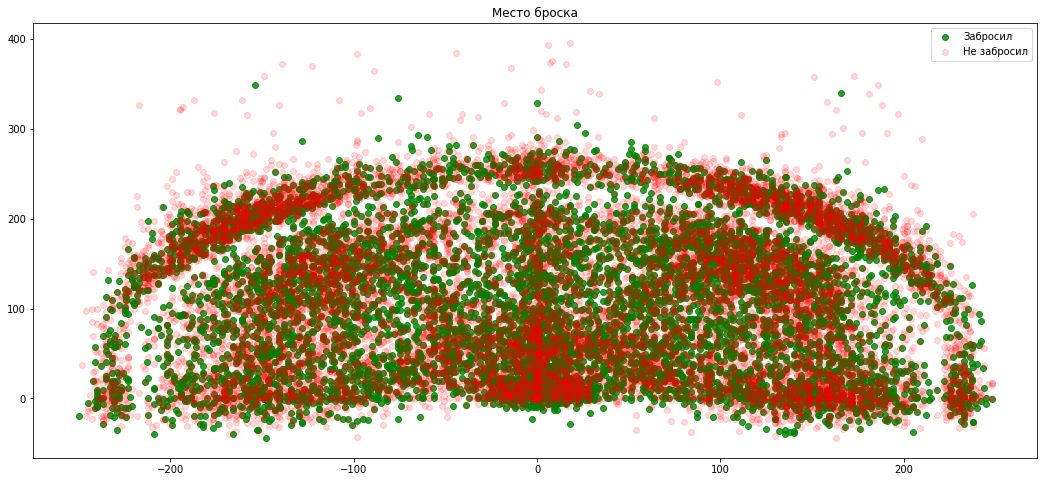

In [ ]:
sm = data[data['shot_made_flag'] == 1]
notsm = data[data['shot_made_flag'] == 0]
plt.figure(figsize=(18, 8))
plt.scatter(sm.loc_x, sm.loc_y, color='green', alpha=0.8, label='Забросил')
plt.scatter(notsm.loc_x, notsm.loc_y, color='red', alpha=0.15, label='Не забросил')
plt.title('Место броска')
plt.legend()
plt.show()

### Работа с переменными

построим матрицу корреляции

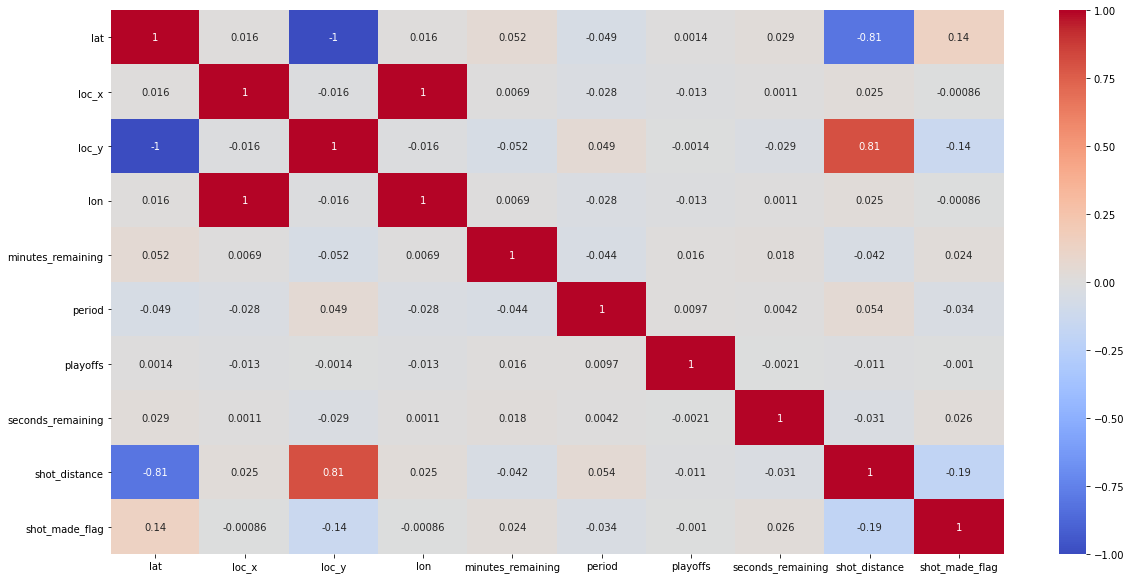

In [ ]:
# визуализируем матрицу
plt.figure(figsize=(20, 10))
get_heatmap(data)

Из нее следует, что переменные lon, lat и loc_x, loc_y имеющие 100% корреляцию - это линейная комбинация друг друга, одну пару можно удалить.

In [ ]:
data.drop(columns=['lon','lat'], inplace=True)

Обратимся к переменной matchup, она показывает с одной стороны кто соперник, с другой - дома или в гостях играет команда Коби. Преобразуем эту переменную:

In [ ]:
data.matchup.value_counts()[0:5]

LAL @ SAS      1019
LAL vs. SAS     932
LAL @ SAC       883
LAL vs. HOU     877
LAL @ DEN       869
Name: matchup, dtype: int64

In [ ]:
data.matchup=data.matchup.apply(lambda x: 'home' if x.find('@')==-1 else 'away')

In [ ]:
data.matchup.value_counts()

away    15689
home    14908
Name: matchup, dtype: int64

Продолжим анализ, кодируем категориальные переменные

In [ ]:
#Обновим список
cat_features = list(data.columns[data.dtypes == object])

In [ ]:
# Обрабатываем категориальные переменные, если категорий немного - применяем OneHotEncoding
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

for i  in cat_features:
    if len(data[i].unique()) < 8:
        data = pd.get_dummies(data, columns=[i])
    else:
        le.fit(data[i])
        data[i] = le.transform(data[i])

In [ ]:
data.shape

(30597, 36)

Итого 35 признаков и 1 целевая переменная. Посмотрим, сколько строк где целевая переменная пустая:

In [ ]:
len(data[data[target].isnull()])

4988

Удаляем строки, где целевая переменная пустая - эти данные нужны, чтобы для них по построенной модели предсказать значения и отправить на соревнование kaggle, а модель по ним строить не получится.

In [ ]:
data = data[~data[target].isnull()]

In [ ]:
# разбиваем данные на признаки и целевую переменную
y = data[target]
X = data.drop(target, axis=1)

# делаем нормирование
from sklearn.preprocessing import StandardScaler
X.loc[:,:] = StandardScaler().fit_transform(X)

### Важность признаков на основе линейных моделей

Обучим линейную модель, Lasso, Ridge (с встроеной регуляризацией) на этом датасете и посмотрим, как меняется величина коэффициентов, какие зануляются:

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

**1. Линейная регрессия**

In [ ]:
model = LinearRegression().fit(X, y)
model.coef_

array([ 2.26159194e-02, -9.49926060e-03,  1.01147833e-02,  7.89724294e-03,
       -1.16121268e-02, -7.39424452e-05,  3.04400806e-03,  1.01183470e-02,
       -6.60081082e-02,  3.33152491e-03, -3.90684924e+10, -1.13748027e+11,
       -4.01863209e+10, -2.42122916e+11, -2.18327770e+11, -4.39425278e+10,
        9.30491728e+09,  9.30491728e+09, -2.65819070e+11, -1.80721636e+11,
       -1.75418376e+11, -1.93839734e+11, -1.91541135e+11,  1.57568719e+11,
       -5.59502404e+10,  3.92462891e+10, -7.67854823e+10, -6.58333928e+10,
        4.61442502e+10,  1.97479322e+11, -4.78501610e+10,  1.83687501e+11,
        2.05203562e+11,  4.23189037e+10,  4.23189037e+10])

In [ ]:
model.score(X,y)

0.06947754839094866

Мы видим, что коэффициенты получились заоблачные, а точность модели близка к нулю. Перейдем к моделям с регуляризацией.—

**2. Модель Lasso**

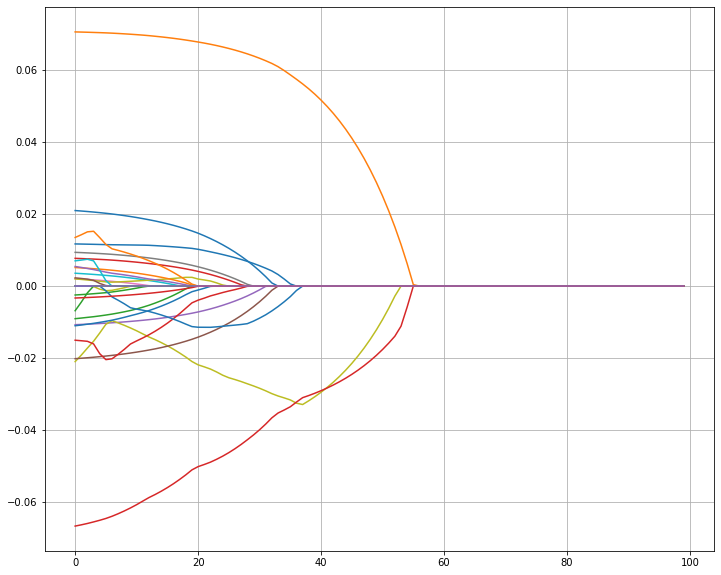

In [ ]:
# Параметр регуляризации alpha - степени двойки от -10 до 2
n_steps = 100
alpha = list(2**np.linspace(-10, 2, n_steps))
# Для каждого значения alpha вызываем обучение Lasso и добавляем в список
coef = [Lasso(alpha=i).fit(X, y).coef_ for i in alpha]

plt.figure(figsize=[12,10])
plt.grid() 

for i in np.vstack(coef).T:
    plt.plot(range(n_steps), i)

Получили картину того, как переменные постепенно зануляются. Посмотрим, какие переменные всё ещё "действуют" в точке step = 30.

In [ ]:
# Сортируем по модулю coef, выбираем из него значения > 0, и для этих значений получаем индексы из coef
def primal_coef(step):
  d = np.argsort(np.abs(coef[step]))[np.sort(np.abs(coef[step])) > 0]
  print(X.columns[d][::-1]) # по индексам из coef в обратном порядке вернем имена признаков

In [ ]:
primal_coef(30)

Index(['combined_shot_type_Dunk', 'combined_shot_type_Jump Shot',
       'shot_distance', 'shot_zone_range_24+ ft.',
       'combined_shot_type_Bank Shot', 'combined_shot_type_Tip Shot',
       'action_type', 'period'],
      dtype='object')


То же самое для почти конечной точки = 50:

In [ ]:
primal_coef(50)

Index(['combined_shot_type_Dunk', 'combined_shot_type_Jump Shot',
       'shot_distance'],
      dtype='object')


Видим, что самые важные признаки - это расстояние, с которого делается бросок, и также два, видимо, излюбленных, либо характерных вида броска.

Сделаем те же рассчеты для Ridge.

**3. Модель Ridge**

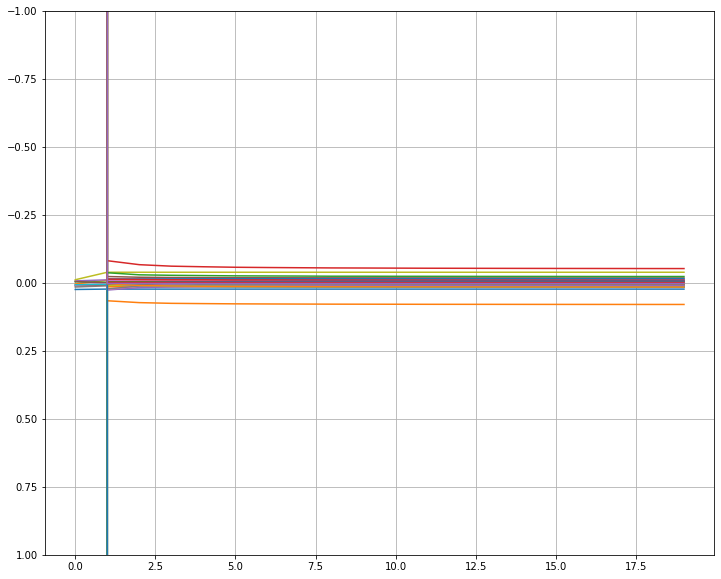

In [ ]:
# Параметр регуляризации alpha
n_steps = 20
alpha = list(np.linspace(0, 0.000000005, n_steps))
# Для каждого значения alpha вызываем обучение Ridge и добавляем в список
coef = [Ridge(alpha=i).fit(X, y).coef_ for i in alpha]

plt.figure(figsize=[12,10])
plt.grid() 
plt.ylim(1,-1)

for i in np.vstack(coef).T:
    plt.plot(range(n_steps), i)

Видим совсем другое поведение коэффициентов, например, для точки 15:

In [ ]:
primal_coef(15)

Index(['combined_shot_type_Dunk', 'combined_shot_type_Jump Shot',
       'shot_distance', 'shot_zone_range_Less Than 8 ft.', 'action_type',
       'combined_shot_type_Tip Shot', 'shot_zone_area_Left Side(L)',
       'shot_zone_range_16-24 ft.', 'combined_shot_type_Bank Shot',
       'shot_zone_range_8-16 ft.', 'combined_shot_type_Layup',
       'shot_zone_area_Right Side Center(RC)', 'period',
       'shot_zone_basic_Above the Break 3', 'seconds_remaining', 'loc_x',
       'shot_zone_basic_In The Paint (Non-RA)', 'minutes_remaining',
       'shot_zone_area_Center(C)', 'shot_type_2PT Field Goal',
       'shot_type_3PT Field Goal', 'shot_zone_range_24+ ft.',
       'shot_zone_area_Right Side(R)', 'opponent',
       'shot_zone_basic_Left Corner 3', 'season', 'loc_y',
       'shot_zone_basic_Restricted Area',
       'shot_zone_area_Left Side Center(LC)', 'matchup_away', 'matchup_home',
       'shot_zone_basic_Right Corner 3', 'combined_shot_type_Hook Shot',
       'shot_zone_basic_Mid-Rang

Последний шаг в этом разделе: отобразим коэффициенты разных моделей на одном графике, приведя к единому масштабу:

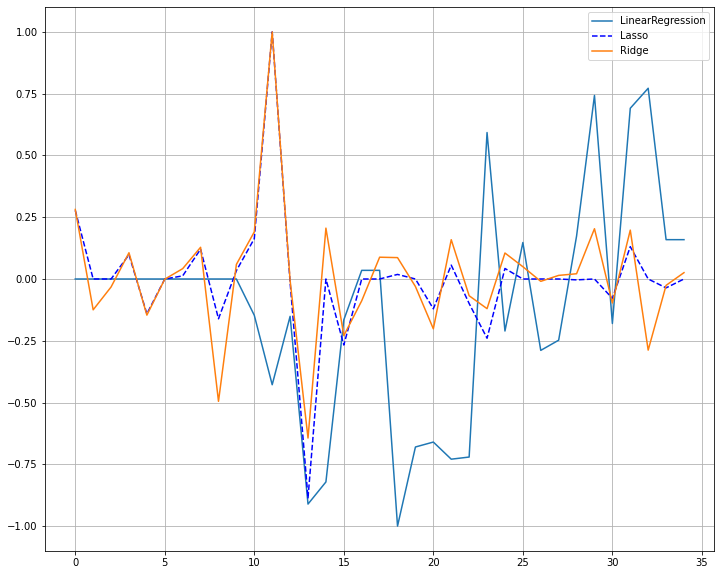

In [ ]:
plt.figure(figsize=[12,10])
plt.grid() 
k1 = LinearRegression().fit(X, y).coef_
k2 = Lasso(alpha=0.002).fit(X, y).coef_
k3 = Ridge().fit(X, y).coef_

plt.plot(range(35), k1/max(abs(k1)), label='LinearRegression')
plt.plot(range(35), k2/max(abs(k2)), 'b--',label='Lasso')
plt.plot(range(35), k3/max(abs(k3)), label='Ridge')
plt.legend()

Можно отметить тот факт, как близки графики Lasso и Ridge и как сильно выделяются значимостью признаки под номерами 11 и 13:

In [ ]:
X.columns[11], X.columns[13]

('combined_shot_type_Dunk', 'combined_shot_type_Jump Shot')

### Сравнение результата моделей на тестовой выборке

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.3)  

In [ ]:
# делаем нормирование
from sklearn.preprocessing import StandardScaler
stX = StandardScaler()
X_train.loc[:,:] = stX.fit_transform(X_train)
X_test.loc[:,:] = stX.transform(X_test)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((17926, 35), (17926,), (7683, 35), (7683,))

Обучим все модели с параметрами по умолчанию на обучающей выборке, и проверим на тестовой, в качестве метрики будем использовать ROC AUC

In [ ]:
# Модели
model1 = LinearRegression().fit(X_train, y_train)
model2 = Lasso().fit(X_train, y_train)
model3 = Ridge().fit(X_train, y_train)

# Предсказания на тесте
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

# подсчет метрики ROC AUC
roc_auc1 = roc_auc_score(y_test, y_pred1)
roc_auc2 = roc_auc_score(y_test, y_pred2)
roc_auc3 = roc_auc_score(y_test, y_pred3)

print(f'ROC AUC LinearRegression: {roc_auc1}')
print(f'ROC AUC Lasso: {roc_auc2}')
print(f'ROC AUC Ridge: {roc_auc3}')

ROC AUC LinearRegression: 0.627420369405908
ROC AUC Lasso: 0.5
ROC AUC Ridge: 0.6274295250673781


Построим графики ROC AUC:

In [ ]:
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)

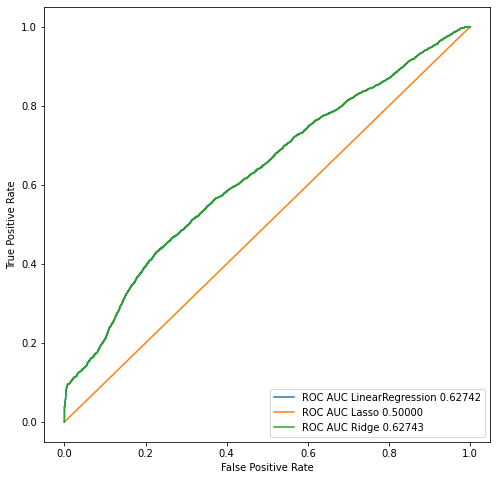

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot(fpr1, tpr1, label=f'ROC AUC LinearRegression {roc_auc1:.5f}')
plt.plot(fpr2, tpr2, label=f'ROC AUC Lasso {roc_auc2:.5f}')
plt.plot(fpr3, tpr3, label=f'ROC AUC Ridge {roc_auc3:.5f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='lower right')
plt.show()    

In [ ]:
# значение ROC AUC для Lasso c alpha, близким к нулю, когда параметры незанулены
roc_auc_score(y_test,
              Lasso(alpha=0.0001, max_iter=10000).fit(X_train, y_train).predict(X_test))

0.6274036011719796

**Вывод:** Модели показали не особо хорошую точность, но при этом Линейная регрессия и модель Ridge демонстрируют идентичный результат. Совершенно нейтральную силу предсказания показала только модель Lasso. Это потому, что параметр alpha для этой модели по умолчанию равен 1, тогда как если посмотреть на график зануления параметров для Lasso, приведённый выше, надо подавать значение alpha, при котором признаки еще не нулевые, — а это близкие к нулю значения.

Если сделать это с Lasso, обнаружится что и эта модель показывает те же самые значения метрики ROC AUC.

### PCA

Построим PCA на подготовленных признаках и посмотрим, какие компоненты составляют наибольшую часть дисперсии целевой переменной:

In [ ]:
# модель РСА для наших признаков и преобразование датафрейма признаков в новый датафрейм после РСА
pca = PCA(n_components=len(X.columns))
X_new = pca.fit_transform(X)

Выведем матрицу ковариации:

In [ ]:
pd.DataFrame(data=X_new).cov().round(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,7.261,0.00,0.000,0.00,-0.00,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.00,-0.000,-0.000,0.000,-0.000,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
1,0.000,4.48,0.000,0.00,-0.00,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.00,-0.000,-0.000,0.000,-0.000,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
2,0.000,0.00,2.224,-0.00,0.00,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.00,0.000,0.000,0.000,0.000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,0.000,0.00,-0.000,2.14,-0.00,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.00,0.000,0.000,0.000,-0.000,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
4,-0.000,-0.00,0.000,-0.00,2.01,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.00,-0.000,0.000,-0.000,0.000,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
5,-0.000,-0.00,0.000,-0.00,0.00,1.595,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.00,0.000,0.000,-0.000,0.000,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
6,-0.000,0.00,-0.000,-0.00,0.00,0.000,1.272,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.00,0.000,-0.000,0.000,0.000,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
7,-0.000,-0.00,-0.000,0.00,0.00,-0.000,0.000,1.216,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.00,-0.000,-0.000,0.000,-0.000,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
8,0.000,0.00,-0.000,-0.00,0.00,0.000,-0.000,0.000,1.191,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.00,0.000,0.000,-0.000,0.000,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
9,0.000,-0.00,0.000,0.00,0.00,-0.000,0.000,-0.000,0.000,1.077,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.00,0.000,0.000,-0.000,0.000,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0


Можно заметить, что перераспределились дисперсии признакового пространства в компоненты преобразованного, при этом взаимная корреляция компонент нулевая.

Выведем значимость компонент:

In [ ]:
print ('Значимость компонент:')
for i in range(len(X.columns)):
    print(f'Компонент: {i}, Дисперсия: {pca.explained_variance_ratio_[i]}')

Значимость компонент:
Компонент: 0, Дисперсия: 0.20744646741710135
Компонент: 1, Дисперсия: 0.12799649939520852
Компонент: 2, Дисперсия: 0.06354889612316836
Компонент: 3, Дисперсия: 0.06114182877244073
Компонент: 4, Дисперсия: 0.057422783747555654
Компонент: 5, Дисперсия: 0.045569217792453286
Компонент: 6, Дисперсия: 0.036345510775583144
Компонент: 7, Дисперсия: 0.03475505836777487
Компонент: 8, Дисперсия: 0.0340142249334453
Компонент: 9, Дисперсия: 0.03078165712605032
Компонент: 10, Дисперсия: 0.029942723749475597
Компонент: 11, Дисперсия: 0.02936096621629848
Компонент: 12, Дисперсия: 0.028921063138204285
Компонент: 13, Дисперсия: 0.02865163181700026
Компонент: 14, Дисперсия: 0.027832642629194555
Компонент: 15, Дисперсия: 0.02696839158381636
Компонент: 16, Дисперсия: 0.025579766287387725
Компонент: 17, Дисперсия: 0.024244205682603895
Компонент: 18, Дисперсия: 0.022423578815035036
Компонент: 19, Дисперсия: 0.019766230369614165
Компонент: 20, Дисперсия: 0.01444633693114251
Компонент: 21

**Вывод:** Первая компонента объясняет 20,7% целевой переменной; вторая - 12,8%. Заметим также, что после 27й компоненты, остальные не оказывают предсказательного влияния, их можно отбрасывать. То есть, изначально в нашем признаковом пространстве было 35 переменных, метод РСА в данном случае позволит сократить это число до 27.  